In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv, OptimalPlayer
import seaborn as sn

In [2]:
env = TictactoeEnv()
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

In [6]:
class QPlayer:
    "Class for a Q-Learning agent player"
    def __init__(self, epsilon, alpha = 0.05, gamma = 0.99, player_name = 'O'):
        """
        Initializer
        INPUTS: 
        - epsilon: exploration level to define the epsilon-greedy policy; the agent takes the best action with probability 1-epsilon
        - alpha: learning rate
        - gamma: discount factor
        - player_name: player symbol on the board
        """
        self.epsilon = epsilon
        self.alpha = alpha 
        self.gamma = gamma 
        self.player_name = player_name 
        self.states = [] # array of states explored by the player
        self.actions = [] # array of actions done by the player
        self.states_value = dict() # dictionary that will store the Q-values at each status 
        
    def set_player(self, player_name = 'O', j=-1):
        """
        Function to set player symbol, needed to alternate the starting player.
        INPUTS:
        - player_name: player symbol on the board
        - j : number of the current game
        """
        self.player_name = player_name
        if j != -1:
            self.player_name = 'O' if j % 2 == 0 else 'X'
            
    def empty(self, grid):
        """
        Function to return available actions given a board situation.
        INPUTS: 
        - grid: current board status
        OUTPUTS:
        - avail: array with available actions
        """
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(i)
        return avail
    
    def get_state_key(self, grid):
        """
        Function transforing the grid configuration into a string, needed for use it as key of a dictionary.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - key: correspondent string
        """ 
        key = str(grid.reshape(3 * 3))
        return key
    
    def select_optimal_action(self, grid):
        """
        Function selecting the available action with the highest Q-value, given a state.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: action with the highest Q-value
        """
        avail_actions = self.empty(grid) # find all available actions
        key = self.get_state_key(grid) # get the string corresponding to the current state
        if key in self.states_value : 
            # IF THE STATE HAS ALREADY BEEN EXPLORED
            restricted_vector = self.states_value[key][avail_actions] # array with the Q-values of the available actions
            idx = np.argmax(restricted_vector).item() # position of maximum of restricted_vector
            move = avail_actions[idx] # move corresponding to the maximum
        else :
            # IF THE STATE IS EXPLORED FOR THE FIRST TIME
            self.states_value[key] = np.zeros([9,1]) # insert the key into the dictionary and a zero-array for the values
            move = self.select_random_action(grid) # pick randomly the action to do 
        return move
    
    def select_random_action(self,grid):
        """
        Function selecting a random available action, given a state.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: a random available action
        """
        key = self.get_state_key(grid) # get the string corresponding to the current state
        # IF THE STATE IS EXPLORED FOR THE FIRST TIME
        if key not in self.states_value:
                self.states_value[key] = np.zeros([9,1]) # insert the key into the dictionary and a zero-array for the values
        actions = self.empty(grid) # find all available actions
        move = random.choice(actions) # pick randomly the action to do
        return move
    
    def act(self,grid):
        """
        Function selecting an available action given a state following the epsilon-greedy policy.
        INPUTS:
        - grid: a board status
        OUTPUTS:
        - move: an available action
        """
        b = np.random.binomial(1,1-self.epsilon) # bernoull
        # choose the action with the highest Q-value with probability 1-epsilon
        if b == 1 : 
            return self.select_optimal_action(grid)
        else : 
            return self.select_random_action(grid)
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
 

In [9]:
class QLearning:
    def __init__(self, epsilon1, epsilon2, alpha = 0.05, gamma = 0.99):
        self.q_player = QPlayer(epsilon1, alpha, gamma)
        self.opponent = OptimalPlayer(epsilon2)
        self.env = TictactoeEnv()
        self.reward_vec = []
        
    def game(self, eps_q_player, eps_opponent_train = 0.5, eps_opponent_test = 0, flag = 'train'):
        self.env.reset()
        self.q_player.actions = []
        self.q_player.states = []
        
        if flag == 'train':
            self.q_player.epsilon = eps_q_player
            self.opponent.epsilon = eps_opponent_train
        else :
            self.q_player.epsilon = 0
            self.opponent.epsilon = eps_opponent_test
            
        
        while not self.env.end : 
            if self.env.current_player == self.q_player.player_name : 
                temp = self.env.grid.copy()
                if flag == 'train':  
                    self.q_player.states.append(temp)
                move = self.q_player.act(self.env.grid)
                self.env.step(move)
                if flag == 'train': 
                    self.q_player.actions.append(move)

            else : 
                move = self.opponent.act(self.env.grid)
                self.env.step(move)
                temp = self.env.grid.copy()
                
        if flag == 'train':    
            self.update_q(self.q_player.player_name,self.q_player.states,self.q_player.actions)
        #print(self.q_player.actions)
        return self.env.reward(self.q_player.player_name)
        
        
    def update_q(self, player, states, actions):
        r = self.env.reward(player)
        i = len(actions)-1
        key = self.q_player.get_state_key(self.env.grid)
        self.q_player.states_value[key] = np.zeros([9,1])
        
        if self.env.current_player == self.q_player.player_name: 
            states.append(self.env.grid.copy())
        
        rev_states = states[::-1]
        #print(rev_states)
            
        for j in range(1,len(rev_states)):
            #print('i',i)
            #print('j',j)
            st = rev_states[j]
            st_prec = rev_states[j-1]
            key = self.q_player.get_state_key(st)
            key_prec = self.q_player.get_state_key(st_prec)
            #print(self.q_player.states_value[key_prec]) 
            self.q_player.states_value[key][actions[i]] += self.q_player.alpha*(r + self.q_player.gamma*max(self.q_player.states_value[key_prec])-self.q_player.states_value[key][actions[i]])  
            r = 0
            i -= 1
        
            #print(self.q_player.states_value[key])
            
    def play_n_games(self, n, epsilon, ntt = 0, get_reward = True):
        r = 0
        for i in range(n):
            self.q_player.set_player('O',i)
            self.opponent.set_player('X',i)
            r += self.game(epsilon[i+ntt], 0.5, flag = 'train')
            if (i+1)%250 == 0 and i != 0 and get_reward:
                self.reward_vec.append(r/250)
                r = 0
                
    def play_train_test(self, epsilon, n_train = 250, n_tot_train = 20000, n_test = 500):
        ntt = 0
        M_opt_vec = []
        M_rand_vec = []
        while ntt < n_tot_train:
            self.play_n_games(n_train, epsilon, ntt, False)
            if ntt!=0 and ntt%n_train == 0 :
                M_opt_vec.append(self.test(n_test,0))
                M_rand_vec.append(self.test(n_test,1))
            ntt += 250
            
        return M_opt_vec, M_rand_vec
    
    def test(self,n_test,epsilon):
        M = 0
        for i in range(n_test):
            M += self.game(0, eps_opponent_test = epsilon, flag = 'test')
        return M/n_test
                
            
    def plot_avg_reward(self, n, epsilon, step=250):
        xx = np.arange(step,n+1,step)
        #print(xx)
        yy = self.reward_vec
        #print(yy)
        fig = plt.figure()
        plt.plot(xx,yy, label = "epsilon="+str(epsilon))
        plt.legend()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        fig.savefig("ploteps_"+str(epsilon)+".png")
        
    def plot_N_star_reward(self,N_star, n, rewards, step = 250):
        xx = np.arange(step,n+1,step)
        fig = plt.figure()
        for i in range(len(N_star)):
            plt.plot(xx,rewards[i], label = 'N*='+str(N_star[i]), linewidth=0.7, )
        plt.legend()
        plt.xlabel("Nb of games")
        plt.ylabel("Avg reward")
        fig.savefig("plotnstar.png")

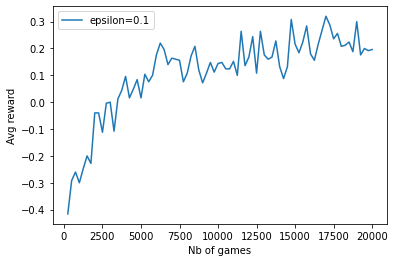

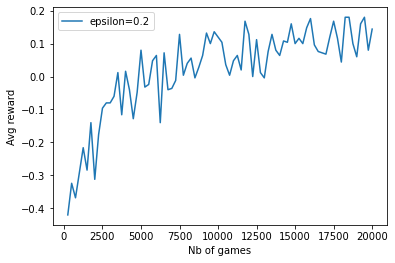

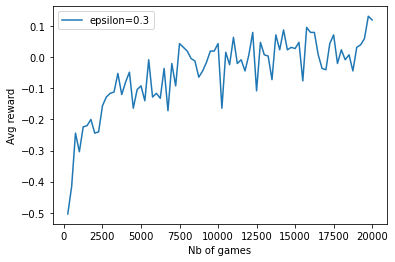

In [33]:
## Question 1
np.random.seed(2022)
eps_vector = [0.1,0.2,0.3]
rew_epsilon = []

N = 20000
for epsilon in eps_vector:
    game = QLearning(epsilon,0.5)
    game.play_n_games(N, epsilon*np.ones(N))
    game.plot_avg_reward(N,epsilon)
    rew_epsilon.append(game.reward_vec)

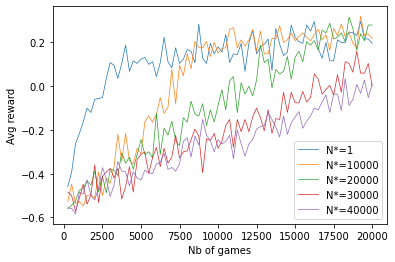

In [10]:
# Question 2
np.random.seed(2022)
e_min = 0.1
e_max = 0.8
rew_N_star = []
N = 20000
N_star_vec = [1, 10000, 20000, 30000,40000]
for N_star in N_star_vec :
    epsilon = []
    for i in np.arange(1,N+1):
        epsilon.append(max(e_min,e_max*(1-i/N_star)))
    game = QLearning(0,0.5)
    game.play_n_games(N,epsilon)
    rew_N_star.append(game.reward_vec)
game.plot_N_star_reward(N_star_vec,N,rew_N_star)
    

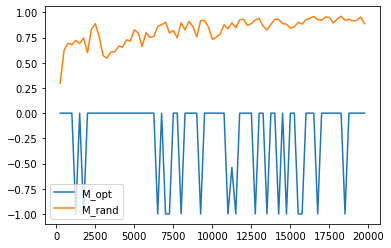

In [53]:
## Question 3
np.random.seed(2022)
epsilon = 0.1
game = QLearning(epsilon, 0.5)
M_opt_vec, M_rand_vec = game.play_train_test(epsilon*np.ones(20000), n_train = 250, n_tot_train = 20000, n_test = 500)
plt.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'M_opt')
plt.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'M_rand')
plt.legend()

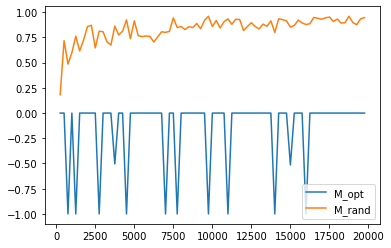

In [54]:
## Question 4
np.random.seed(2022)
epsilon = []
e_min = 0.1
e_max = 0.8
n_tot_train = 20000
N_star = 1 # DA TROVARE
for i in np.arange(1,n_tot_train+1):
    epsilon.append(max(e_min,e_max*(1-i/N_star)))
game = QLearning(0, 0.5)
M_opt_vec, M_rand_vec = game.play_train_test(epsilon, n_train = 250, n_tot_train = 20000, n_test = 500)
plt.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'M_opt')
plt.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'M_rand')
plt.legend()

In [24]:
class SelfQLearning:
    def __init__(self, epsilon1, epsilon2 = 0.5, alpha = 0.05, gamma = 0.99):
        self.q_player1 = QPlayer(epsilon1, alpha, gamma, player_name = 'O')
        self.q_player2 = QPlayer(epsilon1, alpha, gamma, player_name = 'X')
        self.opponent = OptimalPlayer(epsilon2)
        self.env = TictactoeEnv()
        self.reward_vec = []
        
    def game(self, eps_q_player, eps_opponent_train = 0.5, eps_opponent_test = 0, flag = 'train'):
        self.env.reset()
        self.q_player1.actions = []
        self.q_player1.states = []
        self.q_player2.actions = []
        self.q_player2.states = []
        
        if flag == 'train':
            self.q_player1.epsilon = eps_q_player
            self.q_player2.epsilon = eps_q_player
        else :
            self.q_player1.epsilon = 0
            self.opponent.epsilon = eps_opponent_test
            
        
        while not self.env.end : 
            if self.env.current_player == self.q_player1.player_name : 
                temp = self.env.grid.copy()
                if flag == 'train':  
                    self.q_player1.states.append(temp)
                move = self.q_player1.act(self.env.grid)
                self.env.step(move)
                if flag == 'train': 
                    self.q_player1.actions.append(move)
            else : 
                if flag == 'test':
                    move = self.opponent.act(self.env.grid)
                    self.env.step(move)
                else :
                    temp = self.env.grid.copy() 
                    #self.q_player1.states.append(temp)
                    self.q_player2.states.append(temp)
                    move = self.q_player2.act(self.env.grid)
                    self.env.step(move)
                    self.q_player2.actions.append(move)
                    
                
        if flag == 'train':    
            self.update_q(self.q_player1,self.q_player1.states,self.q_player1.actions)
            self.update_q(self.q_player2,self.q_player2.states,self.q_player2.actions)
            
        return self.env.reward(self.q_player1.player_name)
        
        
    def update_q(self, player, states, actions):
        r = self.env.reward(player.player_name)
        i = len(actions)-1
        key = player.get_state_key(self.env.grid)
        self.q_player1.states_value[key] = np.zeros([9,1])
        
        #if self.env.current_player == player.player_name: 
        states.append(self.env.grid.copy())
        
        rev_states = states[::-1]
            
        for j in range(1,len(rev_states)):
            st = rev_states[j]
            st_prec = rev_states[j-1]
            key = player.get_state_key(st)
            key_prec = player.get_state_key(st_prec)
            if key not in self.q_player1.states_value:
                 self.q_player1.states_value[key] = np.zeros([9,1])
            self.q_player1.states_value[key][actions[i]] += self.q_player1.alpha*(r + self.q_player1.gamma*max(self.q_player1.states_value[key_prec])-self.q_player1.states_value[key][actions[i]])  
            r = 0
            i -= 1
            
    def play_n_games(self, n, epsilon, ntt = 0, get_reward = True):
        r = 0
        for i in range(n):
            self.q_player1.set_player('O',i)
            self.q_player2.set_player('X',i+1)
            r += self.game(epsilon[i+ntt], 0.5, flag = 'train')
            if (i+1)%250 == 0 and i != 0 and get_reward:
                self.reward_vec.append(r/250)
                r = 0
                
    def play_train_test(self, epsilon, n_train = 250, n_tot_train = 20000, n_test = 500):
        ntt = 0
        M_opt_vec = []
        M_rand_vec = []
        while ntt < n_tot_train:
            self.play_n_games(n_train, epsilon, ntt, False)
            if ntt!=0 and ntt%n_train == 0 :
                print("Optimal player")
                M_opt_vec.append(self.test(n_test,0))
                print("random player")
                M_rand_vec.append(self.test(n_test,1))
            ntt += 250
            
        return M_opt_vec, M_rand_vec
    
    def test(self,n_test,epsilon):
        M = 0
        for i in range(n_test):
            if self.game(0, eps_opponent_test = epsilon, flag = 'test') != -1 and self.game(0, eps_opponent_test = epsilon, flag = 'test') != 0 :
                print(self.game(0, eps_opponent_test = epsilon, flag = 'test'))
            M += self.game(0, eps_opponent_test = epsilon, flag = 'test')
        return M/n_test
                
            
    def plot_avg_reward(self, n, epsilon, step=250):
        xx = np.arange(step,n+1,step)
        #print(xx)
        yy = self.reward_vec
        #print(yy)
        #fig = plt.figure()
        plt.plot(xx,yy, label = "epsilon="+str(epsilon))
        plt.legend()
        #fig.savefig("ploteps_"+str(epsilon)+".png")
        
    def plot_N_star_reward(self,N_star, n, rewards, step = 250):
        xx = np.arange(step,n+1,step)
        for i in range(len(N_star)):
            plt.plot(xx,rewards[i], label = 'N*='+str(N_star[i]))
            plt.legend()
        

Optimal player
random player
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
-1
1
1
-1
1
1
1
1
1
1
-1
1
-1
0
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
0
-1
1
-1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
-1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
0
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
-1
1
0
1
1
-1
-1
-1
1
1
0
1
1
1
-1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
-1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
-1
1
0
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
0
-1
1
1
1
1
Optimal player
random player
1
0
-1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1

1
1
1
1
1
0
1
1
-1
1
1
1
-1
1
1
1
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
0
-1
-1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
-1
1
0
0
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
-1
-1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
-1
1
1
-1
1
1
1
-1
1
1
1
0
1
1
1
0
-1
1
1
1
1
-1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1

1
1
1
1
-1
1
1
1
-1
1
1
1
-1
1
-1
1
1
-1
-1
1
1
1
Optimal player
random player
1
1
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
1
1
1
-1
-1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
1
-1
1
1
1
1
0
1
0
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
-1
1
1
1
1
0
1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
Optimal player
random player
1
-1
1
1
1
1
0
1
1


1
1
1
1
-1
1
1
1
1
1
0
1
1
1
1
-1
1
1
-1
1
1
1
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
-1
0
1
-1
1
1
1
1
1
1
-1
1
1
1
1
0
-1
1
0
1
1
1
1
1
1
1
1
-1
Optimal player
random player
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
-1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
0
1
0
1
-1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
-1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
-1
1
1
-1
1
1
-1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
-1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
0
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
-

1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
Optimal player
random player
1
1
-1
1
1
-1
1
1
1
-1
1
1
1
0
1
-1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
-1
-1
1
1
1
1
-1
1
1
1
1
1
1
-1
-1
1
1
-1
1
1
1
-1
-1
-1
-1
0
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
-1
1
1
1
1
1
1
-1
-1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
-1
0
1
1
-1
1
1
-1
1
0
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
-1
1
1
-1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
0
1
-1
1
1
-1
1
0
-1
0
1
1
1
1
1
1
1
1
0
1
0
1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
0
-1
1
-1
1
1
0
1
1
0
1
1
1
1
1
-1
-1
1
1
-1
-1
1
0
1
1
1
0
-1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
-1
1
1
1
1
-1
1
0
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
0
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
-1
-1
1
1
-1
1
1
1
1
-1
0
-1
1
1
-1
-1
1
1
1
1
-1
1
-1
-1
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
-1
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
-1
0
1
1
1
1
1
1
1
0
1
1
-1
1
-1
1
1
1
1
1
1
-1
1
1
0
Optimal player
random player
0
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
-1
0
1
1
1
1
1
1
1
-1
0
1
0
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
1

-1
1
1
1
-1
1
1
0
0
1
1
1
-1
1
1
1
1
1
1
-1
1
0
1
0
1
-1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
-1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
0
1
-1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
0
0
0
1
-1
1
1
1
1
0
0
-1
1
1
1
1
1
1
1
1
1
0
1
0
-1
1
1
-1
0
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
0
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
-1
1
1
-1
1
1
1
1
-1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
-1
1
1
-1
1
1
-1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
-1
1
0
1
1
-1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
0
-1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
-1
-1
1
1
1
0
-1
1
1
0
-1
0
1
-1
1
-1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
-1
-1
1
1
-1
1
1
1
1
1
1
-1
-1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
-1
-1
1
1
0
1
0

1
-1
1
0
1
1
1
-1
1
1
1
-1
-1
1
1
1
0
1
1
1
1
1
1
-1
1
0
-1
1
0
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
0
1
0
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
0
Optimal player
random player
-1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
-1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
-1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
-1
-1
1
1
1
1
1
1
0
1
1
1
1
1
-1
1
1
1
1
1
0
1
-1
1
1
1
-1
1
1
1
1
1
-1
1
-1
1
1
-1
0
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
-1
-1
1
-1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
-1
1
1
0
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
-1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
-1
1
1
1
1
1
-1
1
-1
1
1
1
1
-1
1
1
1
0
1
-1
1
0
1
-1
1
1
-1
-1
1
1
1
0
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
-1
1
0
-1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
-1
1
-1
1
-1
1
1
1
-1
1

-1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
0
-1
1
1
1
1
-1
1
-1
1
1
-1
1
1
1
1
1
1
0
0
1
1
1
0
1
-1
1
-1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
-1
1
1
0
1
1
1
-1
1
1
1
-1
1
0
1
1
1
1
0
1
1
1
1
1
1
-1
0
-1
1
1
1
1
0
-1
1
1
-1
1
1
1
-1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
-1
1
1
1
1
1
-1
1
1
1
-1
1
1
-1
-1
0
1
-1
-1
1
1
1
1
-1
1
-1
1
-1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
-1
-1
1
1
1
-1
1
1
1
0
1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
-1
-1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
0
0
1
1
1
0
-1
-1
1
1
1
-1
0
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
-1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
Optimal player
random player
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
-1
0
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
0
1
1
1
1
-1
1
-1
1
1
-1
0
1
1
1
1
-1
1
1
-1
-1
1
1
0
1
-1
1
-1
1
1
-1
-1
1
1
1
1
1
-1
1
1
1
1

1
1
-1
0
1
Optimal player
random player
-1
0
-1
1
1
0
-1
-1
1
0
1
1
1
-1
-1
-1
1
-1
1
1
0
1
1
1
-1
1
1
-1
1
1
1
-1
1
1
-1
1
1
-1
-1
0
1
1
-1
1
1
0
-1
1
1
-1
1
-1
1
1
1
-1
1
1
-1
1
-1
1
1
1
1
0
1
1
1
1
0
-1
1
-1
-1
-1
-1
0
-1
-1
0
1
-1
0
1
1
1
1
-1
1
-1
1
1
-1
1
-1
1
1
1
1
1
1
-1
-1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
0
1
0
1
1
-1
-1
1
0
1
1
1
0
1
-1
1
1
-1
-1
0
1
-1
1
1
1
1
-1
1
1
1
-1
1
0
-1
1
-1
-1
1
1
1
-1
1
-1
1
-1
1
-1
0
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
0
1
1
0
1
1
1
1
1
0
1
0
-1
0
1
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
0
-1
0
-1
-1
1
-1
1
-1
1
-1
1
-1
-1
1
-1
1
1
1
1
-1
1
-1
-1
1
1
1
1
1
-1
1
-1
1
-1
1
1
-1
0
1
1
1
-1
1
1
-1
1
-1
1
1
1
-1
1
-1
1
-1
1
-1
1
-1
1
1
0
1
1
1
1
-1
1
1
-1
0
1
1
0
1
1
1
1
1
-1
1
1
-1
1
1
1
1
-1
1
1
-1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
-1
-1
0
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
1
-1
1
1
1
0
-1
1
1
1
1
1
1
-1
-1
-1
1
1
0
1
1
1
-1
1
-1
1
-1
1
1
1
-1
-1
-1
1
1
1
-1
1
0
1
1
1
-1
1
-1
-1
1
1
-1
-1
1
-1
1
0
-1
-1
1

1
1
Optimal player
random player
1
1
1
0
1
1
-1
1
-1
0
1
1
1
1
1
-1
1
1
1
1
1
0
1
1
-1
1
1
1
1
-1
1
-1
1
0
0
-1
-1
1
0
1
1
1
1
0
-1
1
-1
1
1
1
-1
0
1
1
-1
1
1
1
1
0
1
1
1
1
1
1
1
1
-1
-1
0
-1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
-1
-1
-1
1
0
1
-1
-1
-1
-1
-1
1
1
1
0
1
1
1
0
1
0
1
-1
1
-1
1
1
-1
-1
-1
1
1
1
1
1
1
-1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
-1
-1
-1
1
-1
1
0
1
1
1
1
0
-1
1
1
-1
0
1
0
1
1
1
1
1
-1
1
1
0
1
1
-1
1
1
1
1
1
0
1
0
1
1
1
-1
0
1
0
1
1
-1
-1
1
0
0
1
1
1
-1
-1
-1
1
0
0
-1
0
-1
-1
1
0
1
1
-1
1
1
1
1
-1
1
1
-1
1
-1
-1
-1
1
1
-1
-1
1
-1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
0
1
-1
1
-1
1
-1
1
-1
0
-1
1
1
1
1
1
-1
-1
-1
1
1
1
-1
-1
-1
0
0
0
-1
1
1
1
-1
-1
-1
1
1
0
0
1
0
1
1
0
0
0
1
0
-1
1
1
1
-1
-1
1
-1
1
1
1
-1
1
1
1
1
1
0
1
1
1
-1
Optimal player
random player
-1
1
1
0
1
1
1
1
-1
1
-1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
-1
1
-1
1
1
-1
1
1
1
1
0
1
1
-1
-1
1
1
1
0
1
-1
1
-1
-1
1
1
-1
1
1
0
1
0
-1
1
1
1
1
1
1
-1


1
-1
1
1
1
0
1
1
-1
1
0
1
1
1
1
1
1
1
-1
1
0
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
0
1
1
1
1
1
-1
0
1
1
1
1
1
-1
1
1
1
1
-1
1
1
0
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
-1
1
0
0
1
1
1
1
1
-1
1
1
1
1
1
1
0
-1
-1
1
1
0
1
1
1
-1
1
1
1
1
0
1
1
1
1
1
1
-1
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
0
1
-1
1
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
-1
0
-1
1
1
1
0
1
1
-1
1
1
0
0
1
-1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
0
1
0
-1
1
0
0
1
1
-1
1
0
1
1
1
1
1
-1
1
1
1
1
-1
-1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
0
1
1
1
1
1
1
-1
0
0
1
1
-1
1
0
1
1
1
0
0
1
1
1
1
0
1
-1
1
1
-1
1
1
1
1
1
-1
-1
-1
1
-1
1
1
1
1
1
-1
1
0
1
-1
1
-1
1
1
1
1
1
1
-1
1
0
1
-1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
-1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
-1
1
1
1
1
1
-1
-1
0
1
1
-1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
-1
1
-1
-1
-1
1
-1
-1
1
1
-1
1
1
1
-1
1
1
0
1
1
1
1
1
1
1


1
1
1
1
-1
-1
1
1
1
1
1
1
1
-1
0
0
1
1
1
1
1
1
1
-1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
0
1
1
-1
-1
-1
1
1
1
1
1
1
1
-1
1
-1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
0
0
0
1
0
0
1
1
0
1
1
1
1
0
1
1
1
0
1
1
-1
0
1
1
1
1
1
1
0
1
-1
1
0
-1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
Optimal player
random player
1
-1
0
-1
-1
1
1
1
1
0
1
1
1
1
0
-1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
0
1
-1
1
0
1
1
1
1
1
-1
-1
0
1
-1
1
1
1
1
-1
1
-1
0
1
-1
-1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
0
0
0
-1
1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
-1
-1
-1
1
1
1
-1
0
1
-1
1
0
1
1
-1
0
-1
0
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
-1
1
1
1
-1
-1
0
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
-1
-1
-1
1
0
1
1
1
1
0
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
0
0
1
-1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
-1
1
-1
1
1
1
1
1
1
0
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
-1
1
1
1
0
1
-1
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
-1
0
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
0
0
-1
1
1
0
1
1
1
1
1
-1
-1
-1
-1

1
-1
1
1
1
-1
1
1
-1
0
1
1
1
0
1
1
1
-1
-1
-1
-1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
-1
1
1
-1
-1
1
1
1
1
1
1
-1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
-1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
0
1
-1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
-1
1
1
1
0
1
1
1
-1
0
1
1
-1
-1
-1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
1
1
1
1
1
1
0
0
1
1
1
-1
1
0
-1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
1
1
-1
1
1
-1
1
-1
1
1
1
1
1
-1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
-1
1
-1
1
-1
1
1
1
1
1
1
1
-1
1
-1
0
-1
1
1
1
1
1
-1
-1
0
0
1
0
1
1
1
1
-1
0
-1
1
1
-1
-1
1
-1
1
-1
1
0
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
1
1
1
1
1
0
0
-1
-1
1
1
1
1
1
1
0
1
Optimal player
random player
1
1
1
-1
1
1
0
1
1
1
-1
1
1
1
1
1
1
0
-1
1
1
-1
-1
1
1
1
0
1
1
1
-1
1
1
0
1
1
0
1
1
1
1
1
1
0
1
1
1
-1
-1
1
1
1
1
1
1
0
1
-1
1
1
-1
1
1
1
1
1
1
1
0
1
0
1
1
-1
1
-1
1
1
1
0
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
0
0
1
0
-1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
-

1
0
1
1
1
1
-1
1
1
1
1
0
-1
1
1
1
1
1
1
-1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
-1
1
0
1
1
-1
1
1
-1
1
1
1
1
1
0
1
1
1
1
Optimal player
random player
1
-1
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
-1
0
1
1
0
1
-1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
-1
-1
0
1
1
1
1
1
1
0
1
-1
1
1
0
-1
1
1
1
1
1
1
1
-1
0
1
0
1
1
1
1
1
1
1
0
0
0
1
1
1
1
-1
0
1
1
1
0
1
1
1
-1
0
1
1
-1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
-1
0
-1
1
1
-1
1
-1
1
1
-1
-1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
0
-1
-1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
0
0
1
1
-1
1
1
1
-1
0
1
1
-1
1
1
1
1
1
1
1
1
-1
1
0
0
1
0
1
1
-1
1
1
1
1
1
1
-1
1
1
1
-1
1
0
0
-1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
-1
1
-1
1
1
1
0
-1
1
1
1
-1
0
1
0
1
1
1
1
0
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
-1
1
1
1
0
0
1
0
1
-1
0
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
-1
-1
1
1
1
1
-1
1
1


1
1
-1
0
-1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
0
1
1
1
1
1
-1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
1
1
1
0
1
1
1
1
1
1
-1
0
1
1
1
0
1
1
1
0
1
1
1
-1
1
0
1
1
1
-1
1
-1
1
-1
1
-1
1
1
1
-1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
-1
1
1
1
-1
0
0
1
1
-1
-1
1
1
1
-1
0
1
1
1
1
-1
1
1
-1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
0
-1
1
1
0
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
0
1
Optimal player
random player
0
0
1
1
1
-1
1
1
-1
1
1
1
1
0
1
0
1
1
1
-1
1
1
1
-1
1
0
-1
1
-1
0
1
0
1
1
1
-1
1
1
-1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
0
0
0
1
-1
1
1
1
1
1
1
0
0
1
1
0
1
1
-1
1
0
1
1
0
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
0
-1
1
1

1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
-1
1
-1
0
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
-1
1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
-1
1
-1
1
-1
1
1
1
1
1
1
Optimal player
random player
1
0
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
0
-1
0
1
1
1
1
0
1
-1
1
0
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
-1
-1
1
0
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
1
0
1
1
1
-1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
0
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
-1
-1
1
1
1
1
0
1
1
1
1
1
1
1
1
-1
-1
1
1
1
0
1
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
-1
0
1
1
1
1
1
-1
1
0
0
1
1
1
-1
0
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
0
-1
1
1
1
1
1
0
0
1
1
1
1
1
-1
1
1
1
0
1
1
0
-1
1
1
1
-1
0
-1
1
1
1
1
-1
-1
1
1
-1
1
1
-1
-1
1
1
-1
-1
1
-1
1
1
1
0
1
1
-1
1
1
1
0
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
-1
-1
1
-1
1
1


1
1
1
1
1
-1
1
1
Optimal player
random player
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
0
1
0
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
0
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
0
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
-1
0
0
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
1


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
0
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1

1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
0
1
0
1
1
0
0
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
0
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1


-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
-1
1
0
1
1
1
0
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
-1
1
-1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
Optimal player
random player
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1


1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
-1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
Optimal player
random player
1
0
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
0
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
Optimal player
random player
1
1
1
-1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
-1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


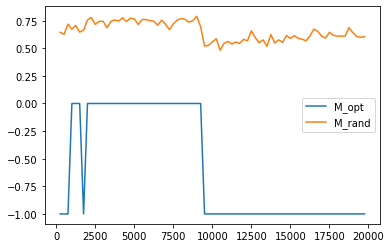

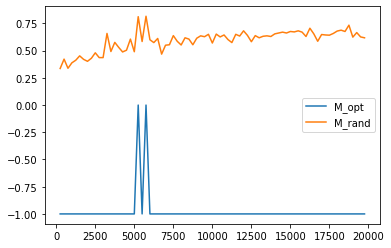

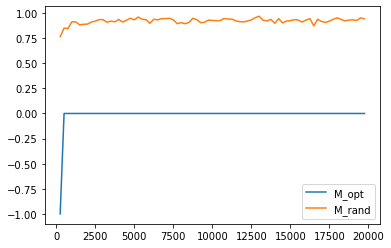

In [25]:
## Question 5
np.random.seed(2022)
eps_vector = [0.1,0.2,0.3]
rew_epsilon = []

for epsilon in eps_vector:
    game = SelfQLearning(epsilon)
    M_opt_vec, M_rand_vec = game.play_train_test(epsilon*np.ones(20000), n_train = 250, n_tot_train = 20000, n_test = 500)
    plt.figure()
    plt.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'M_opt')
    plt.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'M_rand')
    plt.legend()



<AxesSubplot:>

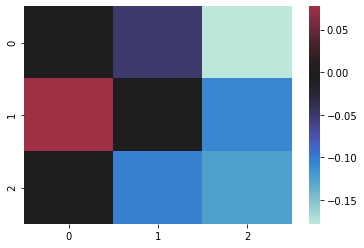

In [6]:
#Question 10
states1 = game.q_player1.get_state_key(np.array([[1, 0., 0.], [0., -1, 0.], [1, 0., 0.]]))
sn.heatmap(game.q_player1.states_value[states1].reshape(3,3), center=0)